### Questions

### Objectives
YWBAT
- explain gradient descent in logistic regression
    - what is the purpose of gradient descent?
        - minimize the loss function
            $$ \log(L) = \log((y - y_{hat})^2) $$
        - finding the lowest point of the loss function
        - starting at some set of beta parameters
        - calculate the gradient at that point then adjust the beta parameters
        - beta parameters are adjusted by
            - $B_{new} = B_{old} - \alpha * G(B)$
    - how is gradient descent different in logistic regression?
        - the cost function is different, because it's a  logloss function, because yhat is a sigmoid
    - what are important hyper-parameters of gradient descent?
        - learning rate
        - number of iterations
        - cost function
        - tolerance
        - C 
        - regularization parameter
            - Lasso - l1
            - Ridge - l2
    - what is/are another example of a sigmoid function?
        - $\tanh(x)$
        - erf
- iterate through models to solve a problem

### Outline

In [133]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, SelectFdr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
breast_cancer = load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target
features = breast_cancer.feature_names

In [16]:
df = pd.DataFrame(data, columns=features)
df['target'] = target
print(df.shape)
df.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [38]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [21]:
df.target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [20]:
# Let's do some eda
feature_corr = []
for feature in features:
    corr = np.corrcoef(df[feature], target)[0][1]
    feature_corr.append([feature, corr, np.abs(corr)])
    
feature_corr = sorted(feature_corr, key=lambda x: x[2], reverse=True)
feature_corr[:5]

[['worst concave points', -0.7935660171412687, 0.7935660171412687],
 ['worst perimeter', -0.7829141371737581, 0.7829141371737581],
 ['mean concave points', -0.7766138400204345, 0.7766138400204345],
 ['worst radius', -0.7764537785950383, 0.7764537785950383],
 ['mean perimeter', -0.7426355297258318, 0.7426355297258318]]

### Let's do more EDA but first let's look at features

In [163]:
kbest = SelectKBest(chi2, k=5)

In [165]:
kbest.fit_transform(df.drop('target', axis=1), df['target'])

array([[ 122.8 , 1001.  ,  153.4 ,  184.6 , 2019.  ],
       [ 132.9 , 1326.  ,   74.08,  158.8 , 1956.  ],
       [ 130.  , 1203.  ,   94.03,  152.5 , 1709.  ],
       ...,
       [ 108.3 ,  858.1 ,   48.55,  126.7 , 1124.  ],
       [ 140.1 , 1265.  ,   86.22,  184.6 , 1821.  ],
       [  47.92,  181.  ,   19.15,   59.16,  268.6 ]])

In [166]:
kbest.get_support()

array([False, False,  True,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False])

In [148]:
X_5 = df.loc[:, kbest.get_support()].drop("worst perimeter", axis=1)
X_5.head()

,mean perimeter,mean area,area error,worst radius
0,122.80,1001.0,153.40,25.38
1,132.90,1326.0,74.08,24.99
2,130.00,1203.0,94.03,23.57
3,77.58,386.1,27.23,14.91
4,135.10,1297.0,94.44,22.54


In [123]:
X_5.shape, df.target.shape

((569, 11), (569,))

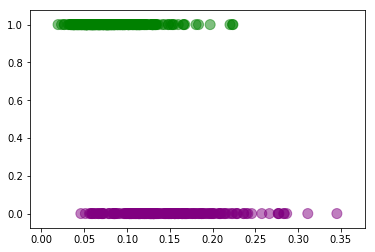

In [124]:
colors = ['green' if j == 1 else 'purple' for j in df.target]
plt.scatter(df['mean compactness'], df.target, c=colors, s=100, alpha=0.5)
plt.show()

In [167]:
scaler = StandardScaler()
scaler.fit(X_5)
X_5_scaled = scaler.transform(X_5)

### build a baseline model

In [168]:
logreg = LogisticRegression(verbose=2, n_jobs=-1)

In [169]:
xtrain, xtest, ytrain, ytest = train_test_split(X_5_scaled, target, test_size=0.20)

In [170]:
logreg.fit(xtrain, ytrain)

[LibLinear]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=2,
                   warm_start=False)

In [171]:
logreg.score(xtest, ytest), logreg.score(xtrain, ytrain)

(0.9122807017543859, 0.9208791208791208)

In [172]:
logreg.coef_[0]

array([-0.86521626,  0.99808964, -1.35927999, -4.05730792])

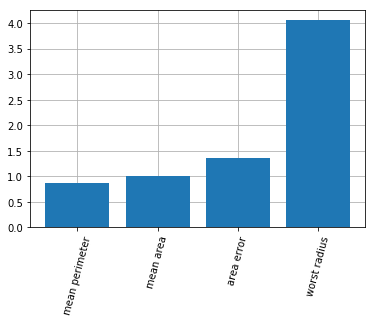

In [173]:
plt.bar(x=range(len(X_5.columns.values)), height=list(np.abs(logreg.coef_[0])), zorder=3)
plt.grid(zorder=0)
plt.xticks(range(len(X_5.columns.values)), X_5.columns, rotation=75)
plt.show()

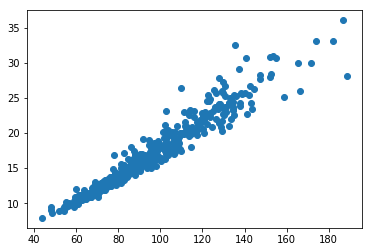

In [118]:
plt.scatter(df["mean perimeter"], df["worst radius"])

In [131]:
preds = logreg.predict(xtest)
cm = confusion_matrix(ytest, preds)

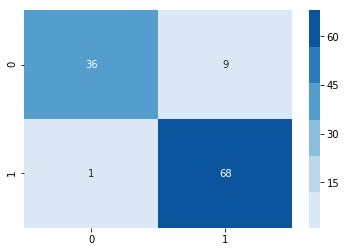

In [132]:
sns.heatmap(cm, fmt='0g', annot=True, cmap=sns.color_palette('Blues'))

### Assessment
- Learnt about making models to figure out which features to focus on
- I learned about `SelectKBest`
- I learned that the loss function for logistic regression is actually the log loss function because we take the log of the squared error for calculating the min. I am also still pretty hazy on logistic gradient descent though… probably need more practice.